<a href="https://colab.research.google.com/github/AshishSalunkhe/Topic-Modelling/blob/master/newsgroup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages
The core packages used in this tutorial are re, gensim, spacy and pyLDAvis. Besides this we will also using matplotlib, numpy and pandas for data handling and visualization. Let’s import them.

In [12]:
!pip install warnings
!pip install pyLDAvis

  Could not find a version that satisfies the requirement warnings (from versions: )
No matching distribution found for warnings


In [0]:
import pandas as pd
import numpy as np
from pprint import pprint
import re

In [0]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# spacy for lemmatization

In [0]:
import spacy

# Plotting Tools

In [10]:
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Prepare Stopwords
We have already downloaded the stopwords. Let’s import them and make it available in stop_words.

In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Newsgroups Data
We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11k newsgroups posts from 20 different topics. This is available as newsgroups.json.

This is imported using pandas.read_json and the resulting dataset has 3 columns as shown.

In [18]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


# Remove emails and newline characters
As you can see there are many emails, newline and extra spaces that is quite distracting. Let’s get rid of them using regular expressions.

In [21]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


After removing the emails and extra spaces, the text still looks messy. It is not ready for the LDA to consume. You need to break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process.

Gensim’s simple_preprocess is great for this.

# Tokenize words and Clean-up text

Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.
Gensim’s simple_preprocess() is great for this. Additionally I have set deacc=True to remove the punctuations.

In [22]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


# Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [23]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


# Remove Stopwords, Make Bigrams and Lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's call the functions in order

In [25]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


# Create the Dictionary and Corpus needed for Topic Modeling
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [32]:
id2word[60]

'card'

In [33]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatev', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

# Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# View the topics in LDA model
The above LDA model is built with 20 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using lda_model.print_topics() as shown next.

In [37]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.013*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

# Compute Model Perplexity and Coherence Score
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful.

In [39]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754093392200653

Coherence Score:  0.515758393754623


# Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and the associated keywords. There is no better tool than pyLDAvis package’s interactive chart and is designed to work well with jupyter notebooks.

In [40]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      16.244669        1       1  0.336874  0.001190
13     15.224102        1       2  0.291046  0.003240
18     14.581161        1       3  0.328823  0.128125
2       6.162413        1       4  0.091751 -0.226490
15      5.974064        1       5  0.059637 -0.222490
10      4.344126        1       6 -0.085006  0.113064
17      4.177528        1       7  0.060773  0.183159
12      3.603081        1       8 -0.021552  0.036676
5       3.365274        1       9 -0.022905  0.021306
16      3.271726        1      10 -0.029259 -0.219704
6       3.222450        1      11 -0.063024  0.016652
9       2.968454        1      12 -0.062882 -0.139433
14      2.740066        1      13 -0.088884  0.062642
3       2.731153        1      14 -0.047749  0.117430
8       2.291951        1      15 -0.111450 -0.003697
19      2.124722        1      16 -0.113691  0.023413
11      2.077352        1      17 -0.092438  0.110492
4       1.694701        1      18 -0.134203 -0.001626
0       1.679200        1      19 -0.164223  0.028009
1       1.521805        1      20 -0.131638 -0.031959, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4146   Default  57084.000000            ax  57084.000000  30.0000  30.0000
21     Default  12491.000000          line  12491.000000  29.0000  29.0000
82     Default  16291.000000           not  16291.000000  28.0000  28.0000
30     Default  11142.000000  organization  11142.000000  27.0000  27.0000
3721   Default   3843.000000           max   3843.000000  26.0000  26.0000
65     Default  10452.000000            do  10452.000000  25.0000  25.0000
322    Default   9655.000000         write   9655.000000  24.0000  24.0000
55     Default   7586.000000       article   7586.000000  23.0000  23.0000
244    Default   8046.000000            be   8046.000000  22.0000  22.0000
154    Default  11782.000000         would  11782.000000  21.0000  21.0000
303    Default   6905.000000           say   6905.000000  20.0000  20.0000
226    Default   5803.000000            go   5803.000000  19.0000  19.0000
29     Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
16     Default   4083.000000          host   4083.000000  17.0000  17.0000
118    Default   6852.000000           get   6852.000000  16.0000  16.0000
46     Default   5027.000000    university   5027.000000  15.0000  15.0000
1911   Default   1863.000000         space   1863.000000  14.0000  14.0000
215    Default   2294.000000        window   2294.000000  13.0000  13.0000
36     Default   3735.000000             s   3735.000000  12.0000  12.0000
18     Default   7291.000000          know   7291.000000  11.0000  11.0000
50     Default   3461.000000          year   3461.000000  10.0000  10.0000
317    Default   4598.000000           use   4598.000000   9.0000   9.0000
2726   Default   1540.000000          game   1540.000000   8.0000   8.0000
23     Default   1949.000000          mail   1949.000000   7.0000   7.0000
681    Default   3006.000000         right   3006.000000   6.0000   6.0000
967    Default   1685.000000     christian   1685.000000   5.0000   5.0000
1362   Default   1746.000000    government   1746.000000   4.0000   4.0000
567    Default   1464.000000          team   1464.000000   3.0000   3.0000
206    Default   3380.000000        system   3380.000000   2.0000   2.0000
60     Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
11736  Topic20    119.371208          guru    120.323120   4.1773  -5.3260
3548   Topic20    117.623718  countersteer    118.575630   4.1772  -5.3407
10436  Topic20    113.026375       bradley    113.978287   4.1769  -5.3806
280    Topic20    112.217010          lane    113.168922   4.1768  -5

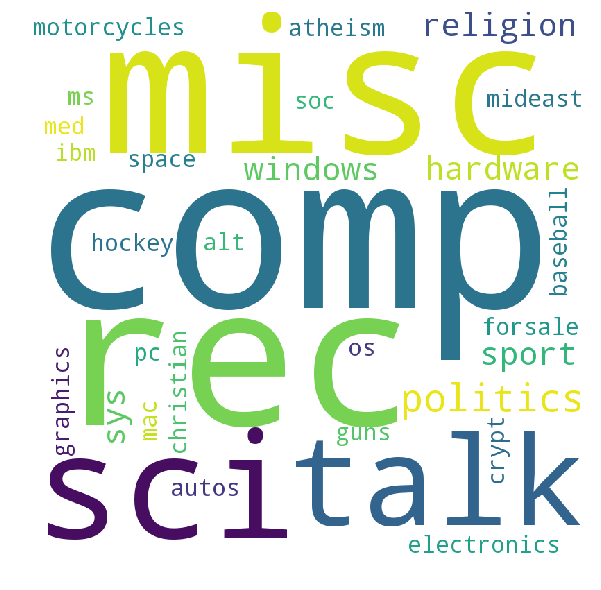

In [62]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df.target_names.unique(): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
     comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
